In [ ]:
import os
import sys
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.io as sio
import anndata as ad
import matplotlib.pyplot as plt

os.chdir("/data/wuqinhua/scPhase/Age")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: 

# 1. UMAP

In [ ]:
adata = sc.read_h5ad("./ensemble_adata_with_attention.h5ad")

In [ ]:

attnData = adata.obs
attnData.to_csv('metadata.csv')

In [ ]:
sc.settings.verbosity = 1
sc.settings.figdir = './Analysis/Figure/Attn_plot'
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=400,
    facecolor = 'white', figsize=(6,6), format='png')

In [ ]:
idList = attnData['Tube_id'].unique()
for id in idList:
    attnTmp = attnData[attnData['Tube_id'] == id]
    avgScore = 1 / len(attnTmp)
    log_attn = np.log2(attnTmp['attention_weight_mean'] / avgScore)
    attn_scaled = (log_attn - np.mean(log_attn)) / np.std(log_attn)
    attn_scaled_clipped = np.clip(attn_scaled, -1, 1)
    attnData.loc[attnData['Tube_id'] == id, 'attn_scaled'] = attn_scaled_clipped

In [ ]:

adata.obs["attn_scaled"] = attnData["attn_scaled"].values
adata1 = adata[adata.obs['Age_group'] == "A"]
adata2 = adata[adata.obs['Age_group'] == "B"]
adata3 = adata[adata.obs['Age_group'] == "C"]
adata4 = adata[adata.obs['Age_group'] == "D"]
adata5 = adata[adata.obs['Age_group'] == "E"]

### 1.1 UMAP of celltype

In [ ]:
leiden_umap = sc.pl.umap(adata, color=['celltype'],
    show=False,  palette=sns.color_palette("husl", 24),
legend_fontsize=6, frameon=True, title='celltype', save = "_celltype.pdf")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


### 1.2 UMAP of group

In [ ]:
leiden_umap = sc.pl.umap(adata, color='Age', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='UMAP of Age',save="_Age.pdf") 

### 1.3 UMAP of age group

In [ ]:
leiden_umap = sc.pl.umap(adata, color='Age_group', show=False, legend_fontsize=6, palette =["#FFCCCC", "#999933", "#B0E57C",  "#99CCFF",  "#D2B5E1"],
                           frameon= True, title='UMAP of Age_group',save="_Age_group.pdf") 

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


### 1.4 UMAP of Attention score

In [ ]:
leiden_umap = sc.pl.umap(adata1, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of A',save="_attn_Age_A.pdf") 


In [ ]:
leiden_umap = sc.pl.umap(adata2, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of B',save="_attn_Age_B.pdf") 
leiden_umap = sc.pl.umap(adata3, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of C',save="_attn_Age_C.pdf") 
leiden_umap = sc.pl.umap(adata4, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of D',save="_attn_Age_D.pdf") 
leiden_umap = sc.pl.umap(adata5, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of E',save="_attn_Age_E.pdf") 

# 2. Celltype-level

In [1]:
setwd('/data/wuqinhua/scPhase/Age')
# rm(list = ls())
# gc()

library(tidyr)
library(ggplot2)
library(forestploter)
library(gridExtra)
library(tidyverse)
library(dplyr)
library(broom)
library(ggpubr)
library(randomForest)
library(mice)
library(reshape2)
library(Metrics)
library(ComplexHeatmap)
library(RColorBrewer)
library(fastcluster)
library(ggbeeswarm)
library(circlize)
library(ggrepel)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:bas

In [2]:
attnData = read.csv('./metadata.csv')
head(attnData)
colnames(attnData)

nameAll = unique(attnData$celltype)
nameAll = sort(nameAll)
nameAll

nameList = nameAll

sampleFold = data.frame(id = character(), celltype = character(), fold = numeric())
idList = unique(attnData$Tube_id)
for (id in idList) {
  attnTmp = attnData %>% filter(Tube_id == id)
  avgScore = 1 / dim(attnTmp)[1]
  foldRes = attnTmp %>% group_by(celltype) %>% summarise(res = median(log2(attention_weight_mean/avgScore)))
  dataTmp = data.frame(id = rep(id,dim(foldRes)[1]),
                       celltype = foldRes$celltype,
                       fold = foldRes$res)
  dataTmp_s = dataTmp %>% filter(celltype %in% nameList)
  dataTmp_s$fold = scale(dataTmp_s$fold)
  sampleFold = rbind(sampleFold,dataTmp_s)
}

sampleFold.Table = dcast(sampleFold,id ~ celltype)
rownames(sampleFold.Table) = sampleFold.Table$id
sampleFold.Table$id = NULL

sampleInfo = read.csv('./sample_info.csv')
rownames(sampleInfo) = sampleInfo$Tube_id
sampleInfo = sampleInfo[rownames(sampleFold.Table),]
head(sampleFold.Table)

,X,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,percent.mt,percent.ribo,log2_nCount,log2_nFeature,⋯,CD25.Antibody,CD45RO.Antibody,CD195.Antibody,CD103.Antibody,CD27.Antibody,CD57.Antibody,CD56.Antibody,celltype,attention_weight_mean,attention_weight_std
,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,ALAW-AS044-1_AAAGCAAGTAGCTTGT-1,SeuratProject,5136,1857,4534,20,2.647975,34.34579,12.32643,10.85876,⋯,0.7318639,0.2592793,0.2811411,0.2739068,0.27390676,2.098219,0.1827491,B_Non-switched memory,0.0001129758,4.754561e-05
2,ALAW-AS044-1_AAAGCAATCTCAAGTG-1,SeuratProject,2299,1186,1106,20,3.784254,22.70552,11.16679,10.21189,⋯,0.7561235,0.2488119,0.1921692,0.2208916,0.16259748,2.592221,0.4478869,B_Naive,0.0002346570,1.315360e-04
3,ALAW-AS044-1_AAAGTAGGTGTTGAGG-1,SeuratProject,4775,1984,1841,20,3.790576,23.66492,12.22129,10.95420,⋯,0.7425382,0.3894857,0.2605460,0.2832238,0.05782322,2.307394,0.2373419,B_Non-switched memory,0.0001103942,5.613119e-05
4,ALAW-AS044-1_AACCATGCACCGATAT-1,SeuratProject,4394,1769,3119,20,2.025489,31.79335,12.10132,10.78872,⋯,0.7781739,0.3786367,0.2621530,0.3488768,0.27035518,2.324009,0.3259609,B_Naive,0.0002314819,1.306919e-04
5,ALAW-AS044-1_AACCATGCATGCCACG-1,SeuratProject,4302,1716,1329,20,2.998605,31.45049,12.07079,10.74483,⋯,0.6348208,0.2794714,0.3762262,0.2165804,0.46443983,2.230292,0.2379865,B_Naive,0.0003627575,5.898019e-05
6,ALAW-AS044-1_AACTCAGTCGCCTGTT-1,SeuratProject,3710,1563,1303,20,1.320755,28.73315,11.85720,10.61010,⋯,0.9526391,0.2476698,0.2952704,0.4052125,0.29527038,2.430727,0.4852164,B_Non-switched memory,0.0001053218,5.621675e-05


[1] "X"                     "orig.ident"            "nCount_RNA"           
 [4] "nFeature_RNA"          "nCount_HTO"            "nFeature_HTO"         
 [7] "percent.mt"            "percent.ribo"          "log2_nCount"          
[10] "log2_nFeature"         "log2_mt"               "Donor_id"             
[13] "Age_group"             "Sex"                   "Age"                  
[16] "Tube_id"               "Batch"                 "File_name"            
[19] "Cluster_names"         "Cluster_numbers"       "HLA.DR.Antibody"      
[22] "Pan.Kir.Antibody"      "CD20.Antibody"         "IgM.Antibody"         
[25] "IgD.Antibody"          "CD3.Antibody"          "CD4.Antibody"         
[28] "CD8.Antibody"          "CD45RA.Antibody"       "CD69.Antibody"        
[31] "CD62L.Antibody"        "CD38.Antibody"         "CD194.Antibody"       
[34] "CD25.Antibody"         "CD45RO.Antibody"       "CD195.Antibody"       
[37] "CD103.Antibody"        "CD27.Antibody"         "CD57.Antibody"        
[40] "CD56.Antibody"         "celltype"              "attention_weight_mean"
[43] "attention_weight_std"

[1] "B_Activated"                     "B_Atypical memory"              
 [3] "B_CD5+ B cells"                  "B_Naive"                        
 [5] "B_Naive-IFN"                     "B_Non-switched memory"          
 [7] "B_Plasma cells"                  "B_Switched memory"              
 [9] "B_Transitional"                  "CD4_Exhausted-like memory"      
[11] "CD4_HLA-DR+ memory"              "CD4_Naive"                      
[13] "CD4_Naive-IFN"                   "CD4_Temra"                      
[15] "CD4_Terminal effector"           "CD4_Tfh"                        
[17] "CD4_Th1"                         "CD4_Th1_Th17"                   
[19] "CD4_Th17"                        "CD4_Th2"                        
[21] "CD4_Th22"                        "CD4_Treg cytotoxic"             
[23] "CD4_Treg KLRB1+RORC+"            "CD4_Treg memory"                
[25] "CD4_Treg naive"                  "CD8_HLA-DR+"                    
[27] "CD8_Naive"                       "CD8_Naive-IFN"                  
[29] "CD8_NKT-like"                    "CD8_Proliferative"              
[31] "CD8_Tcm CCR4-"                   "CD8_Tcm CCR4+"                  
[33] "CD8_Tem GZMB+"                   "CD8_Tem GZMK+"                  
[35] "CD8_Temra"                       "CD8_Tmem KLRC2+"                
[37] "CD8_Trm"                         "dn_T"                           
[39] "GD_gd naive"                     "GD_Vd1 GZMB+"                   
[41] "GD_Vd1 GZMK+"                    "GD_Vd2 GZMB+"                   
[43] "GD_Vd2 GZMK+"                    "MAIT"                           
[45] "Myeloid_cDCs"                    "Myeloid_Classical monocytes"    
[47] "Myeloid_Non-classical monocytes" "Myeloid_pDCs"                   
[49] "NK_CD56bright"                   "NK_CD56dim CD57-"               
[51] "NK_CD56dim CD57+"                "NK_CD56dim CD57int"             
[53] "NK_CD56dim CD57low"              "NK_Proliferative"               
[55] "Progenitor"

Using fold as value column: use value.var to override.



,B_Activated,B_Atypical memory,B_CD5+ B cells,B_Naive,B_Naive-IFN,B_Non-switched memory,B_Plasma cells,B_Switched memory,B_Transitional,CD4_Exhausted-like memory,⋯,Myeloid_Classical monocytes,Myeloid_Non-classical monocytes,Myeloid_pDCs,NK_CD56bright,NK_CD56dim CD57-,NK_CD56dim CD57+,NK_CD56dim CD57int,NK_CD56dim CD57low,NK_Proliferative,Progenitor
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A01,NA,0.7257265,NA,0.50948049,-1.10075115,0.2051857,0.1204126,1.0952702,0.6625314,NA,⋯,1.421141,-1.2868016,-1.3627538,-0.9263263,0.4079412,-0.8010677,-0.4774916,0.9562518,1.3713888,0.8369516
A02,0.9415008,1.3090863,0.36292641,0.86861243,2.20858514,0.5806180,-0.6457333,0.2124215,1.0404011,-0.3442181,⋯,4.093748,-0.3306969,-0.7253399,-0.5549256,-0.5099789,-0.4664546,-0.5899292,-0.4928730,0.1315963,0.3042738
A03,-0.3948812,-0.1038816,2.62329128,0.06848157,NA,0.2093336,NA,0.4610540,0.7810375,0.1328070,⋯,2.145218,1.0500995,-0.4643679,-0.8432497,-0.7999543,-0.6518387,-0.7144787,-0.7475352,-0.2217012,0.7971406
A04,0.2241430,1.8675663,2.00600561,0.08682816,0.02974379,1.1568378,-0.9685962,0.9473374,-0.3848048,1.2428891,⋯,3.024367,-0.7726596,-0.9757970,0.1437182,0.4926964,-0.8316621,-0.3496010,-0.1236320,0.6358062,0.9116007
A05,0.7644734,1.2283841,-0.03241174,0.58173337,3.14968368,0.8299076,-0.6894860,1.7043068,1.0540599,-0.4329185,⋯,3.311884,0.2067334,-0.7430369,-0.2494354,-0.2991518,-0.5603619,-0.5182137,-0.1828354,1.0357016,0.8568718
A06,0.3570711,1.4598751,NA,0.34094270,1.58563228,0.3363191,2.3067864,0.7619637,0.4878027,-0.5731985,⋯,-0.445978,-0.8114174,-0.8976718,-0.4798843,-0.3932081,-0.5292229,-0.8440431,-0.3357745,3.1809139,0.4862932


### 2.1 Scatter trend plot

In [3]:
if (!all(rownames(sampleFold.Table) %in% rownames(sampleInfo))) {
  stop("Not all samples in sampleFold.Table are recorded in sampleInfo.")
}
sampleInfo <- sampleInfo[rownames(sampleFold.Table), ]

# --- 1. Calculate Score One: Correlation with Age (Phenotype Association) ---
phenotype_association_scores <- data.frame(
  cell_type = character(),
  correlation_rho_with_age = numeric(),
  p_value = numeric()
)

for (cell in colnames(sampleFold.Table)) {
  if (sd(sampleFold.Table[[cell]], na.rm = TRUE) == 0) next
  test_result <- cor.test(
    sampleFold.Table[[cell]], 
    sampleInfo$Age, 
    method = "pearson"
  )

  phenotype_association_scores <- rbind(
    phenotype_association_scores,
    data.frame(
      cell_type = cell,
      correlation_rho_with_age = test_result$estimate,
      p_value = test_result$p.value
    )
  )
}
head(phenotype_association_scores)


# --- 2. Calculate Score Two: Group Stability/Volatility (Overall Variation) ---
overall_variation_scores <- data.frame(
  cell_type = character(),
  overall_sd = numeric() 
)

for (cell in colnames(sampleFold.Table)) {
  sd_val <- sd(sampleFold.Table[[cell]], na.rm = TRUE)

  overall_variation_scores <- rbind(
    overall_variation_scores,
    data.frame(
      cell_type = cell,
      overall_sd = sd_val
    )
  )
}
head(overall_variation_scores)


combined_scores_final <- merge(phenotype_association_scores, 
                               overall_variation_scores, 
                               by = "cell_type")

combined_scores_final <- combined_scores_final %>%
  mutate(
    label = ifelse(p_value < 0.05, cell_type, "") 
  )
  
head(combined_scores_final)

,cell_type,correlation_rho_with_age,p_value
,<chr>,<dbl>,<dbl>
cor,B_Activated,-0.5934491,4.466833e-29
cor1,B_Atypical memory,-0.6664250,1.111265e-41
cor2,B_CD5+ B cells,-0.4624998,9.688914e-13
cor3,B_Naive,-0.6050873,4.822220e-33
cor4,B_Naive-IFN,-0.3616314,9.176133e-10
cor5,B_Non-switched memory,-0.6927639,1.713351e-46


,cell_type,overall_sd
,<chr>,<dbl>
1,B_Activated,0.8743653
2,B_Atypical memory,1.1581489
3,B_CD5+ B cells,1.0519650
4,B_Naive,0.7720426
5,B_Naive-IFN,1.1081258
6,B_Non-switched memory,0.8851753


,cell_type,correlation_rho_with_age,p_value,overall_sd,label
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,B_Activated,-0.5934491,4.466833e-29,0.8743653,B_Activated
2,B_Atypical memory,-0.6664250,1.111265e-41,1.1581489,B_Atypical memory
3,B_CD5+ B cells,-0.4624998,9.688914e-13,1.0519650,B_CD5+ B cells
4,B_Naive,-0.6050873,4.822220e-33,0.7720426,B_Naive
5,B_Naive-IFN,-0.3616314,9.176133e-10,1.1081258,B_Naive-IFN
6,B_Non-switched memory,-0.6927639,1.713351e-46,0.8851753,B_Non-switched memory


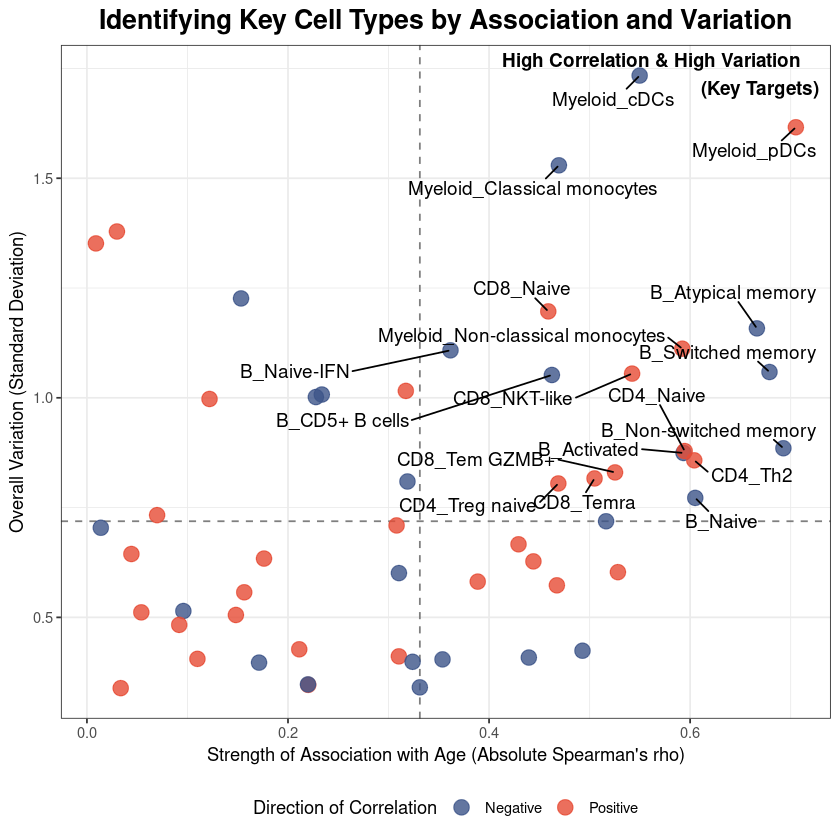

In [4]:
rho_threshold <- median(abs(combined_scores_final$correlation_rho_with_age), na.rm = TRUE)
sd_threshold <- median(combined_scores_final$overall_sd, na.rm = TRUE)

plot_data_final <- combined_scores_final %>%
  mutate(
    direction = ifelse(correlation_rho_with_age > 0, "Positive", "Negative"),
    
    label_text = ifelse(
      abs(correlation_rho_with_age) > rho_threshold & overall_sd > sd_threshold, 
      cell_type, 
      ""
    )
  )


threshold_scatter_plot <- ggplot(plot_data_final, 
                                 aes(x = abs(correlation_rho_with_age), 
                                     y = overall_sd, 
                                     color = direction,
                                     label = label_text)) +

  geom_vline(xintercept = rho_threshold, linetype = "dashed", color = "gray50") +
  geom_hline(yintercept = sd_threshold, linetype = "dashed", color = "gray50") +

  geom_point(size = 4, alpha = 0.8) +
  
  geom_text_repel(color = "black", size = 4, max.overlaps = Inf, 
                  box.padding = 0.6, min.segment.length = 0) +
  
  scale_color_manual(
    name = "Direction of Correlation",
    values = c("Positive" = "#E64B35", "Negative" = "#3C5488")
  ) +

  annotate("text", x = Inf, y = Inf, label = "High Correlation & High Variation\n(Key Targets)", 
           hjust = 1.1, vjust = 1.2, color = "black", fontface = "bold", size = 4) +

  theme_bw() +
  labs(
    title = "Identifying Key Cell Types by Association and Variation",
    x = "Strength of Association with Age (Absolute Spearman's rho)",
    y = "Overall Variation (Standard Deviation)"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    legend.position = "bottom"
  )

ggsave("./Analysis/Figure/Attn_plot/threshold_scatter_plot.pdf", threshold_scatter_plot, width = 8, height = 6)
print(threshold_scatter_plot)

### 2.2 R2: Age and Attn

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


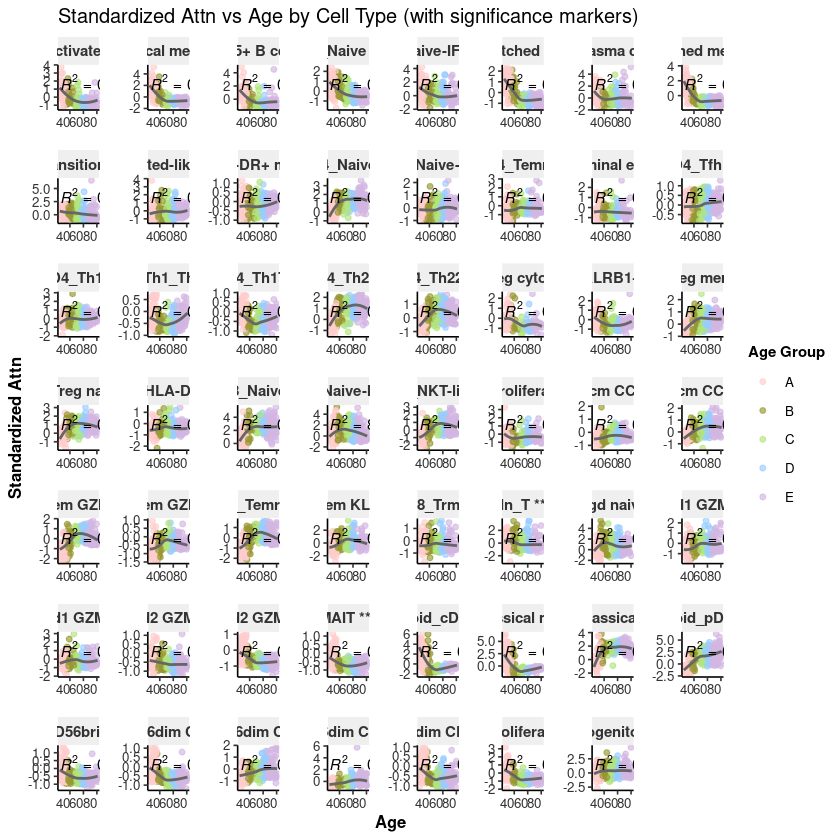

In [6]:
cell_types_attn <- colnames(sampleFold.Table)
combined_data_atten <- data.frame()
for (cell in cell_types_attn) {
  dataTmp <- data.frame(
    atten = sampleFold.Table[[cell]],
    group = sampleInfo$Age_group,
    age   = sampleInfo$Age,
    cell_type = cell
  )
  dataTmp_s <- na.omit(dataTmp)
  combined_data_atten <- rbind(combined_data_atten, dataTmp_s)
}

custom_colors <- c("A" = "#FFCCCC", "B" = "#999933", "C" = "#B0E57C", "D" = "#99CCFF", "E" = "#D2B5E1")

plot_df_attn <- combined_data_atten %>%
  dplyr::select(age, atten, group, cell_type) %>%
  dplyr::rename(Age = age, Attn = atten, Age_group = group) %>%
  dplyr::mutate(Age_group = factor(Age_group, levels = names(custom_colors))) %>%
  na.omit()

significance_labels <- phenotype_association_scores %>%
  mutate(
    significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "**", 
      p_value < 0.05 ~ "*",
      TRUE ~ "ns"
    ),
    title_with_sig = paste0(cell_type, " ", significance)
  ) %>%
  select(cell_type, title_with_sig)
  
plot_df_attn_with_sig <- plot_df_attn %>%
  left_join(significance_labels, by = "cell_type") %>%
  mutate(title_with_sig = ifelse(is.na(title_with_sig), cell_type, title_with_sig))

p_facet_attn_with_r2 <- ggplot(plot_df_attn_with_sig, aes(x = Age, y = Attn)) +
  
  geom_point(aes(color = Age_group), alpha = 0.65, size = 1.3) +

  geom_smooth(
    method = "loess", se = TRUE,
    color = "#666666", fill = "#C9C9C9",
    alpha = 0.22, linewidth = 0.8
  ) +

  ggpubr::stat_cor(
    method = "pearson",
    aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~")), 
    label.x.npc = "left",
    label.y.npc = "top",
    hjust = 0,
    size = 3.2
  ) +
  
  scale_color_manual(values = custom_colors, name = "Age Group") +

  facet_wrap(~title_with_sig, scales = "free", labeller = label_value) +
  
  labs(
    title = "Standardized Attn vs Age by Cell Type (with significance markers)",
    x = "Age",
    y = "Standardized Attn"
  ) +

  theme_classic(base_size = 10) +
  theme(
    panel.background = element_rect(fill = "white", color = NA),
    plot.background  = element_rect(fill = "white", color = NA),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_rect(fill = "#EFEFEF", color = NA),
    strip.text = element_text(size = 9, face = "bold", color = "#333333"),
    axis.text.x = element_text(size = 8, color = "#333333", hjust = 1),
    axis.text.y = element_text(size = 8, color = "#333333"),
    axis.title = element_text(size = 10, face = "bold"),
    legend.position = "right",
    legend.title = element_text(size = 9, face = "bold"),
    legend.text  = element_text(size = 8),
    panel.spacing = unit(0.8, "lines")
  )

ggsave("./Analysis/Figure/Attn_plot/attn_age_scatter_r2_facet_with_sig.pdf",
       p_facet_attn_with_r2, width = 20, height = 18, dpi = 300)

print(p_facet_attn_with_r2)